## Imports

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import gym
import matplotlib.pyplot as plt

## Render

In [0]:
#Render
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

## Hyperparameter

In [0]:
NUM_SAMPLES = 1000
N_CRITIC = 2
ENV_NAME = 'Breakout-v0'
MINI_BATCH_SIZE = 128
LEARNING_RATE_GENERATOR = 4e-5
LEARNING_RATE_DISCRIMINATOR = 4e-5
EPOCHS = 100000
CLIP_WEIGHTS = 0.01
DEVICE = "cuda"
GENER_FILTERS = 64

## Generator

In [0]:
class Generator(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()
    self.conv = nn.Sequential(
        nn.ConvTranspose2d(input_shape[0], GENER_FILTERS * 8, kernel_size=4, stride=1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(GENER_FILTERS * 8),

        nn.ConvTranspose2d(GENER_FILTERS * 8, GENER_FILTERS * 4, kernel_size = 4, stride = 2, padding = 1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(GENER_FILTERS * 4),

        nn.ConvTranspose2d(GENER_FILTERS * 4, GENER_FILTERS * 2, kernel_size = 4, stride = 2, padding = 1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(GENER_FILTERS * 2),

        nn.ConvTranspose2d(GENER_FILTERS * 2, GENER_FILTERS, kernel_size = 4, stride = 2, padding = 1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(GENER_FILTERS)
    )

    conv_out_size = self._get_conv_out(input_shape)

    self.out = nn.Sequential(
        nn.Linear(conv_out_size, 1012),
        nn.LeakyReLU(),
        nn.Linear(1012, np.prod(output_shape)),
        nn.Tanh()
    )
    
    self.output_shape = output_shape

  def _get_conv_out(self, shape):
    out = self.conv(torch.zeros(1, *shape))
    return int(np.prod(out.size()))

  def forward(self, input):
    conv_out = self.conv(input).view(input.shape[0], -1)
    return self.out(conv_out).view((input.shape[0], *self.output_shape))

## Discriminator

In [0]:
class Discriminator(nn.Module):
  def __init__(self, input_shape):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=4, stride=2),
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size=3,stride=1)
    )

    conv_out_size = self._get_conv_out(input_shape)

    self.out = nn.Sequential(
        nn.Linear(conv_out_size, 1012),
        nn.ReLU(),
        nn.Linear(1012, 1),
        # nn.Dropout(0.005),
        nn.Sigmoid()
    )

  def _get_conv_out(self, shape):
    out = self.conv(torch.zeros(1, *shape))
    return int(np.prod(out.size()))

  def forward(self, input):
    conv_out = self.conv(input).view(input.shape[0], -1)
    return self.out(conv_out).squeeze(-1)

## Data

In [13]:
def get_real_data():
  env = gym.make(ENV_NAME)
  env.reset()
  data = []
  for _ in range(NUM_SAMPLES):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    data.append(np.moveaxis(observation, 2, 0))
    if done:
      env.reset()
  env.close()
  data  = np.array(data, dtype=np.float32) * 2 / 255.0 - 1.0
  return torch.FloatTensor(data)

def get_noisy_data(shape):
  return torch.randn(NUM_SAMPLES, 100, 1, 1)

real_data = get_real_data().to(DEVICE)
noisy_data = get_noisy_data(real_data.shape).to(DEVICE)
print(noisy_data.shape)

torch.Size([1000, 100, 1, 1])


## Main Algorithm

Using WGAN - Loss: https://arxiv.org/pdf/1701.07875.pdf

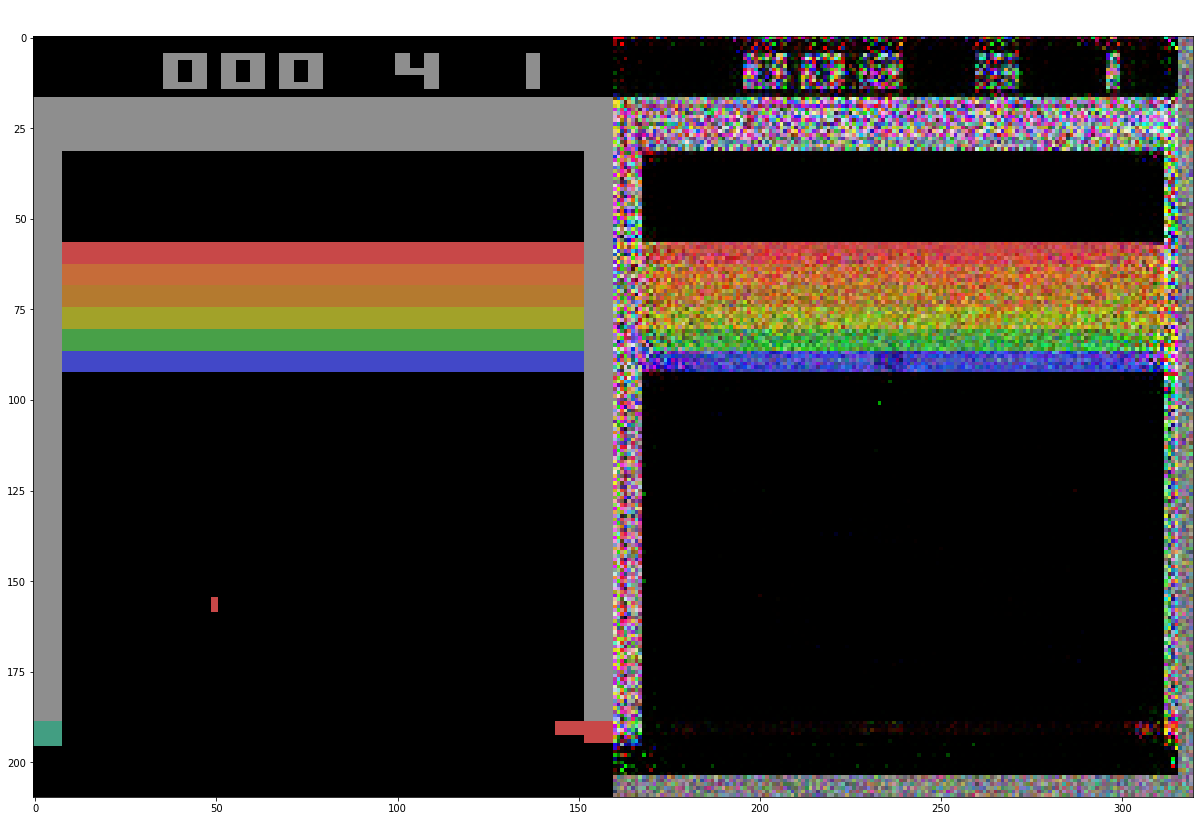

Discriminator loss: -0.006194222718477249 vs. Generator loss -0.5127624273300171


In [0]:
input_shape, output_shape = real_data.shape[1:], real_data.shape[1:]
generator = Generator(noisy_data.shape[1:], output_shape).to(DEVICE)
generator_optimizer = optim.Adam(generator.parameters(), lr = LEARNING_RATE_GENERATOR, betas=(0.5, 0.999))

discriminator = Discriminator(input_shape).to(DEVICE)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr = LEARNING_RATE_DISCRIMINATOR, betas=(0.5, 0.999))


for _ in range(EPOCHS):  
  permutation = torch.randperm(NUM_SAMPLES)
  discriminator_loss, generator_loss = [], []

  for i in range(0, NUM_SAMPLES, MINI_BATCH_SIZE):
    indices = permutation[i:i+MINI_BATCH_SIZE]
    mini_batch_real_data, mini_batch_fake_data = real_data[indices], generator(noisy_data[indices])

    loss = torch.mean(discriminator(mini_batch_fake_data.detach())) - torch.mean(discriminator(mini_batch_real_data))
    discriminator_optimizer.zero_grad()
    loss.backward()
    discriminator_optimizer.step()
    discriminator_loss.append(loss.detach().cpu().numpy())


    for p in discriminator.parameters():
      p.data.clamp_(-CLIP_WEIGHTS, CLIP_WEIGHTS)

    if (i / MINI_BATCH_SIZE) % N_CRITIC == 0:
      loss = -torch.mean(discriminator(mini_batch_fake_data))
      generator_optimizer.zero_grad()
      loss.backward()
      generator_optimizer.step()
      generator_loss.append(loss.detach().cpu().numpy())
      

  plt.figure(figsize = (280,14))
  plt.imshow(np.moveaxis(np.concatenate(((mini_batch_real_data[0].cpu().numpy() + 1) / 2, (mini_batch_fake_data[0].cpu().detach().numpy() + 1) / 2), axis = -1), 0, 2), interpolation='nearest')
  plt.title('Real Image vs. Generated Image', fontsize=30, color = "white")
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  print("Discriminator loss: {} vs. Generator loss {}".format(np.mean(discriminator_loss), np.mean(generator_loss)))